# Génération de gaussienne par modèle de diffusion

<h2>Importation</h2>

In [48]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

<h2>Affichage des points</h2>

<p>Fonction qui prend en argument des points sous forme de tableau numpy ou bien de tensor et qui les affiche</p>

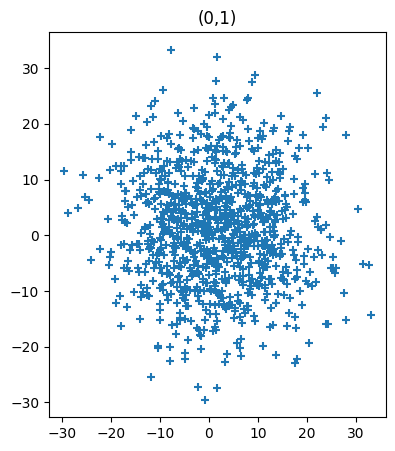

In [44]:
def show_points(X):
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys, marker='+')
    plt.show()
    return

<h2>Modèles</h2>

<p>On utilise différent modèles : 
    <ul>
        <li>Le modèle Net. C'était notre modèle initiale qui contient seulement quelques couches linéaires</li>
        <li>DiffusionBlock : Contient le block du milieu pour le modèle DiffusionModel</li>
        <li>DiffusionModel : Contient un modèle assez similaire à celui utilisé dans le notebook</li>
        <li>Diff : Modèle qui va gérer toute la diffusion</li>
</p>

In [46]:
class Net(nn.Module):
    def __init__(self,inpSize,outpSize, midleSize=128):
        """
        Ce network sert à sampler epsilon_theta (x_t,t)
        """
        super(Net,self).__init__()
        self.inpsize = inpSize
        self.linear1 = torch.nn.Linear(inpSize,128).to(device)
        self.act = torch.nn.ReLU().to(device)
        self.linear2 = torch.nn.Linear(128,outpSize).to(device)
        
    def forward(self,x,t):
        x = x.to(device)
        """
        for i in range(x.shape[0]):
            # modifier x[i] pour encoder le temps
            for j in range(x.shape[1]):
                if j%2 == 0:
                    x[i][j] += np.cos(t[i]/(10000**(j/(2*x.shape[1]))))
                else:
                    x[i][j] += np.sin(t[i]/(10000**(j/(2*x.shape[1]))))
        """
        return self.linear2(self.act(self.linear1(x))).to(device)

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t = t.reshape(-1, 1)
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 1e-4, beta_end = 0.1, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32).to(device)
        #self.betas = self.betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
        
    def add_noise(self, x_start, x_noise, timesteps):
        """
        
        """
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        return x_start * s1+  x_noise * s2
        
    def reverse(self,x,t):
        return self.network(x,t)
        
    def step(self, model_output, timestep, sample):
        # model_output = epsilon_theta, timestep = t, sample = x_t
        # but: avoir x_{t-1}
        t = timestep
        coef_eps_t= ((1-self.alphas[t])/self.sqrt_one_minus_alphas_cumprod[t]).reshape(-1,1).to(device)
        coef_first_t = (1/self.alphas[t] ** 0.5).reshape(-1,1).to(device)
        pred_prev_sample = (coef_first_t*(sample-coef_eps_t*model_output)).to(device)
        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

<h2>Training loop</h2>
<p>La training loop est simple, on optimise pour apprendre le bruit aouté à chaque étape</p>

In [47]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    
    for epoch in range(num_ep):
        if epoch!= 0: print(f"New epoch ({epoch}) last losses: {losses[-1]}" )
        model.train()
        l = 0
        
        for step, batch in enumerate(dataloader):
            batch = batch.to(device) # les x0 avec lesquels je vais me train.
            noise = torch.randn(batch.shape).to(device) # un epsilon par x0 pour les flouter
            timesteps = torch.randint(num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, noise, timesteps) # xt
            noise_pred = model.reverse(noisy, timesteps) # on essaye de prédire le epsilon à partir des images floutées.
            loss = F.mse_loss(noise_pred, noise)
            optim.zero_grad()
            loss.backward()
            optim.step()
            l+=loss.detach().item()
            global_step += 1
        losses.append(l/len(dataloader))

<h2>Dataset</h2>
<p>On créer une classe MultivariateNormalDataset qui permet de générer des points selon différentes distributions gaussiennes. A terme, le but serait d'avoir différentes classe permettant d'avoir différents types de distributions afin de vérifier que ça apprend bien à chaque fois</p>

In [16]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean,std, num_samples):
        self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

<h2>Mise en pratique</h2>

<h3>Gaussiennes</h3>
<p>On commence avec quelques distributions gaussiennes différentes. A noter qu'il semble qu'à chaque fois il est nécéssaire de redéfinir toutes les constantes beta_start, beta_end, nombre de sample et nombre d'étapes de bruitage parce que c'est directement lié au dataset qu'on essaie de générer</p>

In [31]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

#On commence avec une gaussienne centrée en (6, 6) et avec une variance de (2, 2)
mean = 6*torch.ones((dim,))
std = 2*torch.ones((dim,))

dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [32]:

lr = 1e-3
num_epochs = 1000
num_timesteps = 1000
#network =  Net(dim,dim)
#network = network.to(device)
network = DiffusionModel(dim, nblocks=2, nunits=64).to(device)
model = Diff(network,num_timesteps,device = device)
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
training_loop(model,dataloader,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 128.30553255081176
New epoch (2) last losses: 48.78286781311035
New epoch (3) last losses: 16.435366916656495
New epoch (4) last losses: 11.573625230789185
New epoch (5) last losses: 7.129784202575683
New epoch (6) last losses: 4.349935936927795
New epoch (7) last losses: 3.507218027114868
New epoch (8) last losses: 2.0689064264297485
New epoch (9) last losses: 1.8774332046508788
New epoch (10) last losses: 1.3125333070755005
New epoch (11) last losses: 1.1991811037063598
New epoch (12) last losses: 1.1752577781677247
New epoch (13) last losses: 1.1508895397186278
New epoch (14) last losses: 1.0854472637176513
New epoch (15) last losses: 1.0536485671997071
New epoch (16) last losses: 1.059820580482483
New epoch (17) last losses: 1.0433281421661378
New epoch (18) last losses: 1.0668240308761596
New epoch (19) last losses: 1.0382066726684571
New epoch (20) last losses: 1.0322092771530151
New epoch (21) last losses: 1.038092064857483
New epoch (22) last losses: 

In [33]:
def genere_un_point(model):
    sample = torch.randn(dim).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        timesteps = list(range(model.num_timesteps))[::-1]
        for i,t in enumerate(timesteps):
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample) # p(xt-1 | xt), prend en entrée le epislon_theta, et le temps où on est, et la version floutée.
    return sample

In [36]:
X = torch.tensor([])
X = X.to('cpu')
for i in range(1000):
    if i%30 ==0 and i!=0: print(f"generated {i} images.")
    x = genere_un_point(model)
    x = x.to('cpu')
    X = torch.concatenate((X, x))

generated 30 images.
generated 60 images.
generated 90 images.
generated 120 images.
generated 150 images.
generated 180 images.
generated 210 images.
generated 240 images.
generated 270 images.
generated 300 images.
generated 330 images.
generated 360 images.
generated 390 images.
generated 420 images.
generated 450 images.
generated 480 images.
generated 510 images.
generated 540 images.
generated 570 images.
generated 600 images.
generated 630 images.
generated 660 images.
generated 690 images.
generated 720 images.
generated 750 images.
generated 780 images.
generated 810 images.
generated 840 images.
generated 870 images.
generated 900 images.
generated 930 images.
generated 960 images.
generated 990 images.


torch.Size([1000, 2])


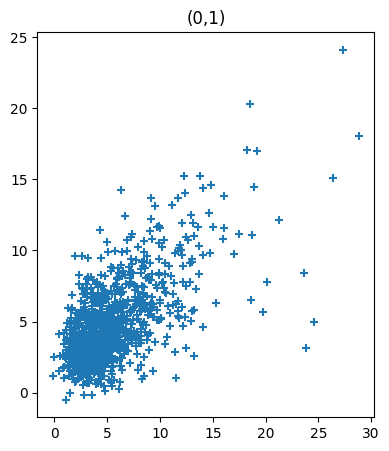

In [37]:
show_points(X)

In [38]:
torch.mean(X, axis=0)
torch.std(X, axis=0)

tensor([5.4473, 4.8015])

In [24]:
class CarreDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        #self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.data = torch.rand(num_samples, 2) * 2 - 1
        self.data += mean
        self.data *= std
        self.num_saples = num_samples
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

torch.Size([10000, 2])


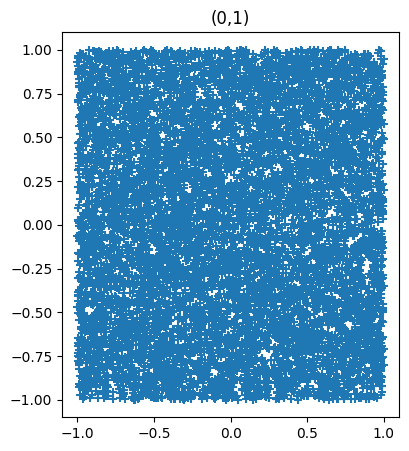

In [25]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 0
std = 1
dataset2 = CarreDataset(mean, std, num_samples)
show_points(dataset2.data)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [26]:
lr = 1e-3
num_epochs = 100
num_timesteps = 200
network2 = Net(dim+1,dim)
network2 = network.to(device)
model2 = Diff(network2,num_timesteps,device = device)
optimizer = torch.optim.Adam(network2.parameters(), lr=lr)
training_loop(model2,dataloader2,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 0.4645091091005947
New epoch (2) last losses: 0.2126347585417592
New epoch (3) last losses: 0.224059598431134
New epoch (4) last losses: 0.20881390160979174
New epoch (5) last losses: 0.21162681511273018
New epoch (6) last losses: 0.21520282106753735
New epoch (7) last losses: 0.21546606939083662
New epoch (8) last losses: 0.20906630133430418
New epoch (9) last losses: 0.22314077558608864
New epoch (10) last losses: 0.22201034862298175
New epoch (11) last losses: 0.2026976500503933
New epoch (12) last losses: 0.21378784110180485
New epoch (13) last losses: 0.21318079669254655
New epoch (14) last losses: 0.2081214698930137
New epoch (15) last losses: 0.20179045264618084
New epoch (16) last losses: 0.20706114910852413
New epoch (17) last losses: 0.20744423314143484
New epoch (18) last losses: 0.20034140824509886
New epoch (19) last losses: 0.2022881108327224
New epoch (20) last losses: 0.19868600995729144
New epoch (21) last losses: 0.19357001457732326
New epoc

(500, 2)


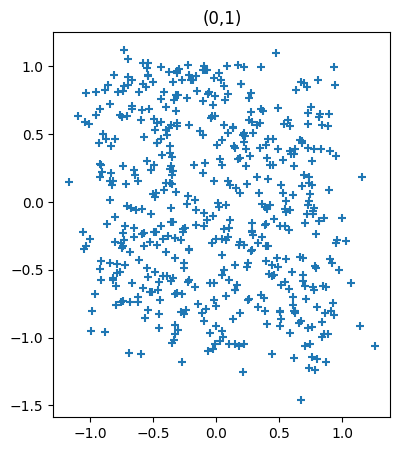

In [27]:
X = []
for i in range(500):
    X.append(genere_un_point(model2)[0])
    #if len(X) % 500 == 0 and len(X)>0:
Y = [x.cpu() for x in X]
show_points(np.array(Y))

In [28]:
class SpiraleDataset(Dataset):
    def __init__(self, theta_max, a, b, num_samples):
        theta = torch.rand(num_samples) * theta_max
        radius = a + b * theta
        self.data = torch.stack((radius * torch.cos(theta), radius * torch.sin(theta)), dim=1)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

torch.Size([10000, 2])


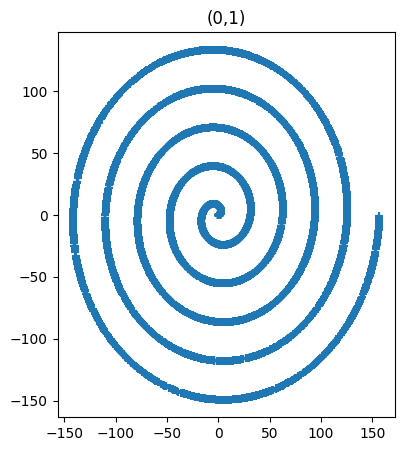

In [29]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 0
std = 1
dataset3 = SpiraleDataset(10 * torch.pi, 0, 5, num_samples)
show_points(dataset3.data)
dataloader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True)

In [30]:
lr = 1e-3
num_epochs = 100
num_timesteps = 500
network3 = Net(dim+1,dim)
network3 = network3.to(device)
model3 = Diff(network3,num_timesteps,device = device)
optimizer = torch.optim.RMSprop(model3.parameters(), lr=lr)
training_loop(model3,dataloader3,optimizer,num_epochs,num_timesteps)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2 and 3x128)

In [ ]:
X = []
for i in range(1000):
    X.append(genere_un_point(model3)[0])
    if len(X) % 125 == 0 and len(X)>0:
        Y = [x.cpu() for x in X]
        show_points(np.array(Y))